# Homework 3

This skeleton of a notebook should get you started on the first part, in which you will have to mask data and handle outliers.  I have included code to format your plots in a way that I like, and to make a plot to visualize the data.  

In [1]:
import numpy as np
from scipy import optimize
from scipy import interpolate
from scipy import stats
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font',**{'family':'serif','serif':['Palatino'],'size': 18})
rc('text', usetex=True)
rc('lines', **{'linewidth':3.0})
rc('axes', **{'labelsize':22})

This plot shows real data from the *Gaia* satellite.  There are a number of fields in this table, which you can access as shown.  I have printed out the names below the short block of code.  You'll use a few of these; I define them below:

`pmra`: motion across the sky (think $x$ direction), measured in angular units per time.  For example, a star moving at 1 milliarcsecond per year (funny astronomer units) would take 3600 years to travel one degree across the sky.

`pmdec`: same as `pmra`, but in the $y$ direction

`ra`, `dec`: position in the sky (don't worry too much about these)

`parallax`: position shift due to the changing perspective of the Earth through the year.  As the Earth moves around the Sun, the apparent positions of the stars change relative to a background very far away.  The distance is related to parallax by 

${\rm distance~in~parsecs} = 1000/{\rm parallax~in~milliarcseconds}$

The parallaxes here are given in units of milliarcseconds.

`radial_velocity`: velocity of the star towards us (if negative) or away from us (if positive), measured in km/s.

The data set provided has a few thousand stars in a cluster, and a bunch more stars scattered through space that happen to be near the cluster in projection.  Your tasks will be to estimate which stars are members of the cluster, to estimate the cluster's proper motion, distance from Earth, and internal motion, and to put error bars on these estimates.  You can see the cluster in the figure: it's the patch of dark blue points (parallaxes around 2.5 milliarcseconds) at proper motions of around -5 in $x$ and +12 in $y$--a patch in velocity space as represented here.

['source_id', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'radial_velocity', 'radial_velocity_error'] 17218 4.985669287075229 -0.8915329065210186


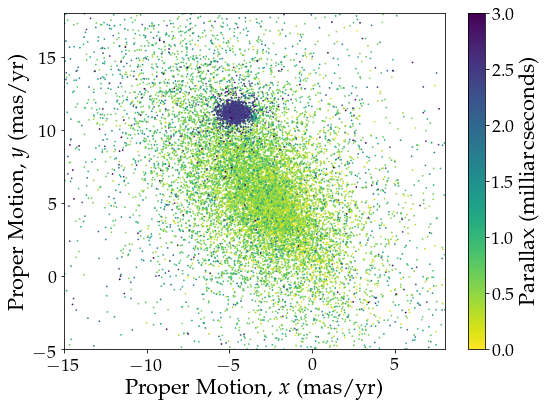

In [2]:
t = fits.open('NGC2516_Gaia.fits.gz')[1].data
print(t.names, len(t), np.amax(t['parallax']), np.amin(t['parallax']))
plt.figure(figsize=(8, 6))
plt.scatter(t['pmra'], t['pmdec'], c=t['parallax'], s=0.5, cmap="viridis_r", vmin=0, vmax=3)
plt.xlim(-15, 8)
plt.ylim(-5, 18)
plt.colorbar(label="Parallax (milliarcseconds)")
plt.xlabel(r"Proper Motion, $x$ (mas/yr)")
plt.ylabel(r"Proper Motion, $y$ (mas/yr)")
plt.tight_layout()
plt.savefig("NGC2516_figure.pdf")

# Part 1a

I will plot the histogram using `pyplot.hist` and then overplot two sample distributions that I will use for the background.  One of these is a simple Gaussian that does not look like a particularly good match.  The other is a lognormal distribution that looks like a much better match.  The lognormal is just a regular Gaussian distribution in the logarithm of a variable (negative values of the variable itself are impossible in this case).  The regular normal distribution takes the form

$\frac{dp}{d\varpi} = \frac{1}{\sqrt{2\pi \sigma^2_\varpi}} \exp \left[ - \frac{\left( \varpi - \langle \varpi \rangle \right)^2}{2 \sigma^2_\varpi} \right]$

while the lognormal is

$\frac{dp}{d\ln \varpi} = \frac{1}{\sqrt{2\pi \sigma^2_{\ln \varpi}}} \exp \left[ - \frac{\left( \ln \varpi - \langle \ln \varpi \rangle \right)^2}{2 \sigma^2_{\ln \varpi}} \right]$

or, equivalently,

$\frac{dp}{d \varpi} = \frac{1}{\varpi \sqrt{2\pi \sigma^2_{\ln \varpi}}} \exp \left[ - \frac{\left( \ln \varpi - \langle \ln \varpi \rangle \right)}{2 \sigma^2_{\ln \varpi}} \right]$.

The amazing and wonderful thing about a mixture model to throw out bad data is that it won't matter much exactly how good the background model is.

/home/tbrandt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


Text(0, 0.5, '$dp/d\\varpi$')

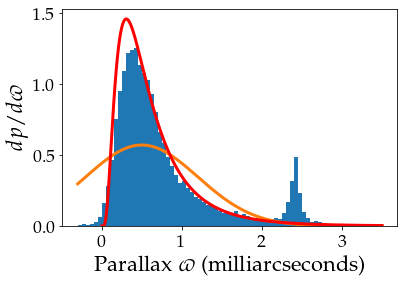

In [3]:
plt.hist(t['parallax'], bins=np.arange(-0.3, 3.5, 0.05), density=True)
x = np.linspace(-0.3, 3.5, 1000)

# This is the Gaussian model: mean 0.5, standard deviation 0.7
plx_bg_mu, plx_bg_sig = [0.5, 0.7]
y = 1/np.sqrt(2*np.pi*plx_bg_sig**2)*np.exp(-(x - plx_bg_mu)**2/(2*plx_bg_sig**2))
plt.plot(x, y)

# This is the lognormal distribution: mean 0.5 (in log(mu)), standard deviation is 0.7 in natural log.
plx_bg_mu, plx_bg_sig = [0.5, 0.7]
y = 1/np.sqrt(2*np.pi*plx_bg_sig**2)*np.exp(-(np.log(x) - np.log(plx_bg_mu))**2/(2*plx_bg_sig**2))
plt.plot(x, y/x, color="red")
plt.xlabel(r"Parallax $\varpi$ (milliarcseconds)")
plt.ylabel(r"$dp/d\varpi$")

In [4]:
def loglike_plx(p, table, f='normal', mu=0.5, sig=0.7):
    
    parallax_cluster = p
    plx = table['parallax']
    var_plx = table['parallax_error']**2
    
    like_member = np.exp(-0.5*(plx - parallax_cluster)**2/var_plx)
    like_member /= np.sqrt(2*np.pi*var_plx)
    
    if f == 'normal':
        like_nonmember = np.exp(-0.5*(plx - mu)**2/(var_plx + sig**2))
        like_nonmember /= np.sqrt(2*np.pi*(var_plx + sig**2))
        like = like_member + like_nonmember
    elif f == 'lognormal':
        # Lognormal: want variance in log(parallax)
        var = table['parallax_error']**2/table['parallax']**2 + sig**2
        like_nonmember = np.exp(-0.5*(np.log(plx) - np.log(mu))**2/var)
        like_nonmember /= plx*np.sqrt(2*np.pi*var)
        # Lognormal cannot handle zero or negative parallaxes
        like = (like_member + like_nonmember)[(plx > 0)]
    else:
        print("Calling likelihood_plx with function type %s not implemented" % (f))
    
    return -np.sum(np.log(like))

plx_normal = optimize.minimize(loglike_plx, [2.4], (t, 'normal'), method="Powell").x
plx_lognormal = optimize.minimize(loglike_plx, [2.4], (t, 'lognormal'), method="Powell").x

print("The parallax with a normal distribution for the background is %.4f mas." % (plx_normal))
print("The parallax with a lognormal distribution for the background is %.4f mas." % (plx_lognormal))

The parallax with a normal distribution for the background is 2.4140 mas.
The parallax with a lognormal distribution for the background is 2.4132 mas.


/home/tbrandt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log


Now I will use bootstrap resampling and log likelihood to get confidence intervals.  I will re-use my code for computing confidence intervals.  I'm plotting the likelihoods with both my normal and lognormal background distribution to show how similar they are, and just how little that ended up mattering.  I'll do the $\Delta \chi^2 = 1$ criterion first.

/home/tbrandt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log


1-sigma uncertainty for a normal background distribution: 0.0010 mas
1-sigma interval for a lognormal background distribution: 0.0010 mas


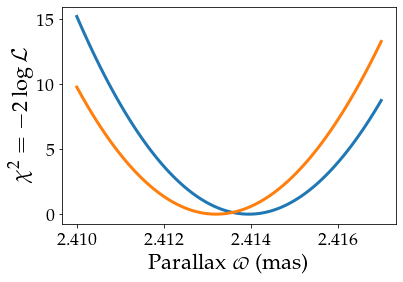

In [5]:
def get_sig(x, chisq, x_best=None, chisq_best=None):
    # The best values of our parameter and of chi squared, if not provided
    if x_best is None:
        x_best = x[chisq == np.amin(chisq)]
    if chisq_best is None:
        chisq_best = np.amin(chisq)
        
    # We interpolate in chi squared. Separately in each half so that the inverse function exists.
    f_low = interpolate.interp1d(chisq[x <= x_best], x[x <= x_best], kind='cubic')
    sig_low = x_best - f_low(chisq_best + 1)
    f_high = interpolate.interp1d(chisq[x >= x_best], x[x >= x_best], kind='cubic')
    sig_high = f_high(chisq_best + 1) - x_best
    
    return [sig_low, sig_high]

# Here is where I compute the chi squared values.

parallax = np.linspace(2.410, 2.417, 100)
chisq_normal = np.zeros(parallax.shape)
chisq_lognormal = np.zeros(parallax.shape)
for i in range(len(parallax)):
    chisq_normal[i] = 2*loglike_plx(parallax[i], t, 'normal')
    chisq_lognormal[i] = 2*loglike_plx(parallax[i], t, 'lognormal')
    
plt.plot(parallax, chisq_normal - min(chisq_normal))
plt.plot(parallax, chisq_lognormal - min(chisq_lognormal))
plt.xlabel(r"Parallax $\varpi$ (mas)")
plt.ylabel(r"$\chi^2 = -2 \log {\cal L}$")

sig_low_normal, sig_high_normal = get_sig(parallax, chisq_normal, x_best=plx_normal)
sig_low_lognormal, sig_high_lognormal = get_sig(parallax, chisq_lognormal, x_best=plx_lognormal)

print("1-sigma uncertainty for a normal background distribution: %.4f mas" % 
      ((sig_low_normal + sig_high_normal)/2))
print("1-sigma interval for a lognormal background distribution: %.4f mas" % 
      ((sig_low_lognormal + sig_high_lognormal)/2))

In [6]:
plist = []
for j in range(200):
    i = np.random.randint(0, len(t), len(t))
    p = optimize.minimize(loglike_plx, [2.4], (t[i], 'normal'), method="Powell").x
    plist += [p]
    
onesig_low = stats.scoreatpercentile(plist, 16)
onesig_high = stats.scoreatpercentile(plist, 84)
print("1-sigma uncertainty from bootstrap resampling: %.4f mas" % (np.std(plist)))

1-sigma uncertainty from bootstrap resampling: 0.0021 mas


It's still small, but the uncertainty from bootstrap resampling is more than twice as large as that from $\Delta \chi^2 = 1$.

## Part 1c: Now let's look at the distributions in proper motion

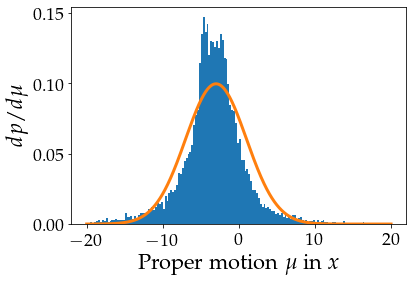

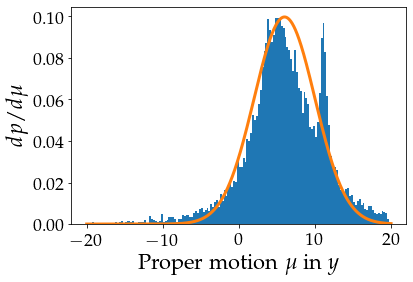

In [7]:
plt.hist(t['pmra'], bins=np.arange(-20, 20, 0.25), density=True)
x = np.linspace(-20, 20, 1000)

# This is the Gaussian model: mean 0.5, standard deviation 0.6
pmra_bg_mu, pmra_bg_sig = [-3, 4]
y = 1/np.sqrt(2*np.pi*pmra_bg_sig**2)*np.exp(-(x - pmra_bg_mu)**2/(2*pmra_bg_sig**2))
plt.plot(x, y)
plt.xlabel(r"Proper motion $\mu$ in $x$")
plt.ylabel(r"$dp/d\mu$")
plt.show()
plt.clf()

plt.hist(t['pmdec'], bins=np.arange(-20, 20, 0.25), density=True)

# This is the Gaussian model: mean 0.5, standard deviation 0.6
pmdec_bg_mu, pmdec_bg_sig = [6, 4]
y = 1/np.sqrt(2*np.pi*pmdec_bg_sig**2)*np.exp(-(x - pmdec_bg_mu)**2/(2*pmdec_bg_sig**2))
plt.plot(x, y)
plt.xlabel(r"Proper motion $\mu$ in $y$")
plt.ylabel(r"$dp/d\mu$")
plt.show()


In [8]:
def loglikelihood(p, table, bgdists, member_prior=0.5, returnprobs=False):
    
    pmra_cluster, pmdec_cluster, parallax_cluster, sig_pmra_cluster, sig_pmdec_cluster = p
    
    # Use the distribution given if the star is a cluster member.  
    
    var_pmra = sig_pmra_cluster**2 + table['pmra_error']**2
    var_pmdec = sig_pmdec_cluster**2 + table['pmdec_error']**2
    var_plx = table['parallax_error']**2
    
    loglike_member = -0.5*(table['pmra'] - pmra_cluster)**2/var_pmra
    loglike_member -= 0.5*(table['pmdec'] - pmdec_cluster)**2/var_pmdec
    loglike_member -= 0.5*(table['parallax'] - parallax_cluster)**2/var_plx
    
    like_member = 1/np.sqrt((2*np.pi)**3*var_pmra*var_pmdec*var_plx)*np.exp(loglike_member)
    
    # Now for the nonmembers!  I'll add the variance in the distributions to the measurement variance.
    
    var_pmra_bg = bgdists['pmra_sig']**2 + table['pmra_error']**2
    var_pmdec_bg = bgdists['pmdec_sig']**2 + table['pmdec_error']**2
    var_plx_bg = bgdists['plx_sig']**2 + table['parallax_error']**2
    
    loglike_nonmember = -0.5*(table['pmra'] - bgdists['pmra_mu'])**2/var_pmra_bg
    loglike_nonmember -= 0.5*(table['pmdec'] - bgdists['pmdec_mu'])**2/var_pmdec_bg
    loglike_nonmember -= 0.5*(table['parallax'] - bgdists['plx_mu'])**2/var_plx_bg
    
    like_nonmember = 1/np.sqrt((2*np.pi)**3*var_pmra_bg*var_pmdec_bg*var_plx_bg)*np.exp(loglike_nonmember)

    # I'm including a check in the likelihood to avoid including any stars whose likelihood 
    # is so close to zero that underflow is a danger.
    
    if not returnprobs:
        like = member_prior*like_member + (1 - member_prior)*like_nonmember
        return -np.sum(np.log(like[like > 1e-300]))
    else:
        prob_member = like_member/(like_member + like_nonmember)
        # If both likelihoods are zero, this is a nonmember.
        prob_member[np.isnan(prob_member)] = 0
        return prob_member

# I'm using a python dictionary here to store the parameter values I want to pass in.

bgdists = {'pmra_mu':-3, 'pmra_sig':4, 'pmdec_mu':6, 'pmdec_sig':4, 'plx_mu':0.5, 'plx_sig':1}

# Initial guesses for the parameters

p = [-5, 12, 2.4, 0.5, 0.5]
p = optimize.minimize(loglikelihood, p, (t, bgdists), method="Powell").x
# Here is our first estimate of the parameters.
print(p)

[-4.67668736 11.16722487  2.41203215  0.51563538  0.44365716]


Ok, now let's see how many stars are probable members ($\geq$50% posterior probability).  

In [9]:
# Let's see how many stars have at least a 50% posterior probability of membership!
p_member = loglikelihood(p, t, bgdists, returnprobs=True)
print("%d out of %d stars have at least a 50%% posterior probability of cluster membership." %
      (np.sum(p_member > 0.5), len(p_member)))

1055 out of 17218 stars have at least a 50% posterior probability of cluster membership.


/home/tbrandt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


This suggests I should use a membership prior of 1055/17218, or about 6%.  Let's see what difference that makes.

In [10]:
p = optimize.minimize(loglikelihood, p, (t, bgdists, 0.06), method="Powell").x
print(p)
p_member = loglikelihood(p, t, bgdists, returnprobs=True)
print("%d out of %d stars have at least a 50%% posterior probability of cluster membership." %
      (np.sum(p_member > 0.5), len(p_member)))

[-4.67758291 11.17234687  2.41412955  0.48194896  0.40742246]
1050 out of 17218 stars have at least a 50% posterior probability of cluster membership.


/home/tbrandt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


It hardly mattered, though the inferred spreads of proper motion within the cluster decrease a little and the cluser parallax increases a tiny bit.  Now let's get uncertainties on all of these values with bootstrap resampling.  This is a bit computationally expensive.

In [11]:
plist = []
p = [-5, 12, 2.4, 0.5, 0.5]
for j in range(200):
    i = np.random.randint(0, len(t), len(t))
    p = optimize.minimize(loglikelihood, p, (t[i], bgdists, 0.06), method="Powell").x
    plist += [p]
    
# Now we'll print the bootstrap means and standard deviations.
print(np.mean(plist, axis=0))
print(np.std(plist, axis=0))
#print("1-sigma uncertainties from bootstrap resampling: %.4f mas" % (np.std(plist)))

[-4.67732599 11.17319124  2.41416481  0.47868947  0.40754021]
[0.01631842 0.01534382 0.00185051 0.01351479 0.01220156]


## Part 1d:

Now we remake the figure with posterior membership probability.  It will make very little difference what membership prior I use, whether 0.5 or 0.06.  The cluster pops out extremely clearly.

/home/tbrandt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


Text(0, 0.5, 'Proper Motion, $y$ (mas/yr)')

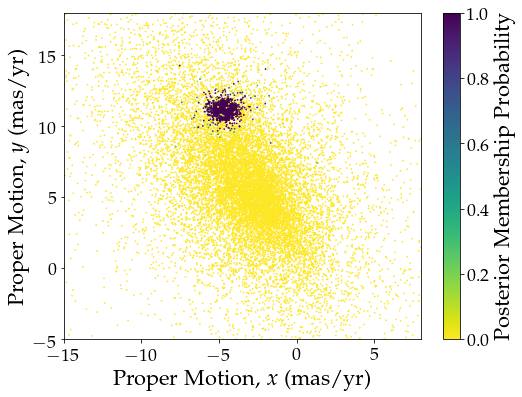

In [12]:
p = [-5, 12, 2.4, 0.5, 0.5]
p = optimize.minimize(loglikelihood, p, (t, bgdists, 0.06), method="Powell").x
p_member = loglikelihood(p, t, bgdists, returnprobs=True)

plt.figure(figsize=(8, 6))
plt.scatter(t['pmra'], t['pmdec'], c=p_member, s=0.5, cmap="viridis_r", vmin=0, vmax=1)
plt.xlim(-15, 8)
plt.ylim(-5, 18)
plt.colorbar(label="Posterior Membership Probability")
plt.xlabel(r"Proper Motion, $x$ (mas/yr)")
plt.ylabel(r"Proper Motion, $y$ (mas/yr)")

NGC_2516  -4.748 0.441 0.017  11.221 0.345 0.014  2.417 0.045 0.002

# Part 2

First, I'll copy over the relevant bits of the HW2 solutions, and re-derive the best-fit model with a diagonal covariance matrix.

In [13]:
nu, T = np.loadtxt('skytemperature.dat').T
nu /= 75
# We'll first define a class to hold some stuff relevant to the linear models.  
# This will be useful later.  I won't end up using all of these attributes.

class Linmodel:
    def __init__(self):
        self.par = None
        self.y = None
        self.cov = None
        self.cov_inv = None
        
def Tmodel_c1c2(c, nu, T, c0=None, data_ivar=None, data_UT=None, exponent=5):
    A = np.ones((len(nu), 6))
    A[:, 0] = 1/nu**2.5
    A[:, 1] = np.log(nu)/nu**2.5
    A[:, 2] = np.log(nu)**2/nu**2.5
    A[:, 3] = 1/nu**4.5
    A[:, 4] = 1/nu**2
    
    # Case where the exponent is fixed; get it from the arguments.
    if len(c) == 2:
        A[:, 5] = np.exp(-np.abs((nu - c[0])/c[1])**exponent)
    # Exponent floats.
    elif len(c) == 3:
        A[:, 5] = np.exp(-np.abs((nu - c[0])/c[1])**(c[2]**2))
    else:
        raise ValueError("Calling Tmodel_c1c2 with an incorrect number of fitting parameters.")
        
    result = Linmodel()
    
    # This is the case where c0 is free; we optimize over it.
    if c0 is None:
        Tfit = np.zeros(len(nu))
        b = T
    else:    # In case we want to hold c0 fixed
        Tfit = A[:, 5]*c0
        A = A[:, :5]
        b = T - Tfit
        
    if data_ivar is not None:
        if data_UT is None: # case of diagonal, 1-D variances
            Ap = A*np.sqrt(data_ivar[:, np.newaxis])
            bp = b*np.sqrt(data_ivar)
            result.cov_inv = np.dot(Ap.T, Ap)  # We need this for part 2c
        else:
            Ap = np.dot(data_UT, A)*np.sqrt(data_ivar)[:, np.newaxis]
            bp = np.dot(data_UT, b)*np.sqrt(data_ivar)
            # I could compute the covariance matrix for the parameters here, but I never use it.
    else:  # Unit variances
        Ap = A
        bp = b
        
    fit = np.linalg.lstsq(Ap, bp, rcond=None)[0]
    Tfit += np.dot(A, fit)

    result.y = Tfit
    result.par = fit
    return result

def chisq_model(par, model, nu, T, kwargs={}):
    if not 'Cdata_inv' in kwargs:
        return np.sum((model(par, nu, T, **kwargs).y - T)**2)
    else:
        Cdata_inv = kwargs['Cdata_inv']
        model_args = kwargs.copy()
        del model_args['Cdata_inv']
        resid = model(par, nu, T, **model_args).y - T
        return np.linalg.multi_dot([resid, Cdata_inv, resid])

cguess = [1.04, 0.13, 2.1]
data_ivar = np.ones(nu.shape)/0.025**2
extra_args = {'data_ivar':data_ivar}
cfit = optimize.minimize(chisq_model, cguess, (Tmodel_c1c2, nu, T, extra_args), method="Powell").x
print("The best-fit parameters are", cfit)
print("The best-fit chi squared is %.2f" % (chisq_model(cfit, Tmodel_c1c2, nu, T)/0.025**2))


The best-fit parameters are [1.04383998 0.13502602 2.14484409]
The best-fit chi squared is 117.63


Ok, now I will define a function to run my MCMC on the model above.

In [14]:
def run_MCMC_Tmodel(x_start, sig, nu, T, data_ivar, N_MCMC):
    npar = len(x_start)
    chain = np.zeros((N_MCMC, npar))
    
    n_trials = np.zeros(len(x_start))
    n_acceptances = np.zeros(len(x_start))
    x = x_start
    model = Tmodel_c1c2(x, nu, T, data_ivar=data_ivar)

    loglike = -0.5*np.sum((T - model.y)**2*data_ivar) 

    # This part marginalizes out the linear parameters.

    loglike -= 0.5*np.log(np.linalg.det(model.cov_inv))

    for i in range(N_MCMC):
        par_to_vary = np.random.randint(npar)
        dx = np.zeros(npar)
        dx[par_to_vary] = np.random.normal()*sig[par_to_vary]
        n_trials[par_to_vary] += 1
    
        model = Tmodel_c1c2(x + dx, nu, T, data_ivar=data_ivar)
        loglike_new = -0.5*np.sum((T - model.y)**2*data_ivar) 
        loglike_new -= 0.5*np.log(np.linalg.det(model.cov_inv))
    
        accept = np.random.rand() < np.exp(loglike_new - loglike)
        if accept:
            n_acceptances[par_to_vary] += 1
            x += dx
            loglike = loglike_new
            
        chain[i] = x
    
    return chain, n_acceptances/n_trials

N_MCMC = 1000
sig = [0.006, 0.006, 0.2]

chain, accept_fraction = run_MCMC_Tmodel(cfit, sig, nu, T, data_ivar, N_MCMC)
print("My acceptance fractions were:", accept_fraction)

My acceptance fractions were: [0.24512535 0.22522523 0.30519481]


Now that these are reasonable, I will run a chain of $10^5$ points.  I'll choose a starting guess that is a little bit off (too far off and you're in trouble--you'll fall into a different local minimum and take a very, very long time to climb out with the step sizes above!)

In [15]:
xstart = [1, 0.2, 1.5]
sig = [0.006, 0.006, 0.2]

chain, accept_fraction = run_MCMC_Tmodel(xstart, sig, nu, T, data_ivar, 100000)
print(accept_fraction)

[0.26190908 0.27408796 0.31840288]


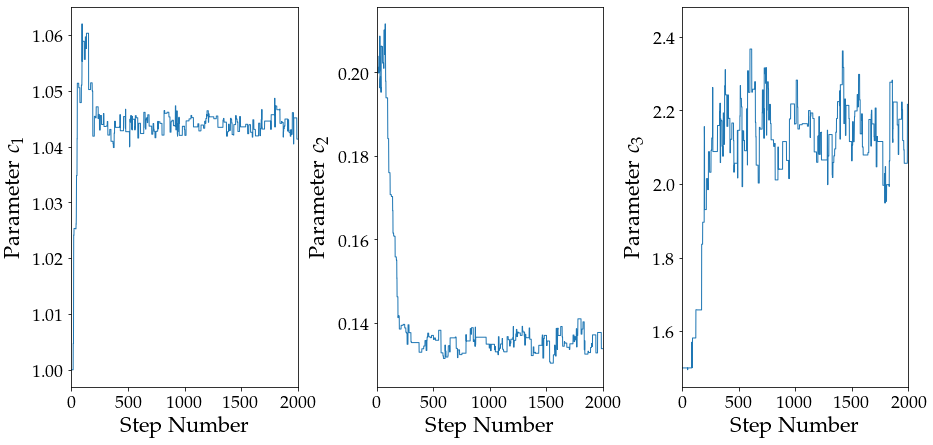

In [16]:
chain = np.array(chain)
xmax = 2000
step = np.arange(chain.shape[0])

f, ax = plt.subplots(1, 3, figsize=(15, 7), gridspec_kw={'wspace':0.35})

for par in range(3):
    ax[par].plot(step, chain[:, par], lw=1)
    ax[par].set_xlabel("Step Number")
    ax[par].set_ylabel(r"Parameter $c_{%d}$" % (par + 1))
    ax[par].set_xlim(0, xmax)


It looks like the burnin took about 500 steps--not bad at all.  We do have to be careful.  If I ended up in a local minimum, it might _look_ like the chain is burned-in, but that would not be true at all.  For example, try the above procedure, but with an initial guess of
`[0.9, 0.2, 1.5]`

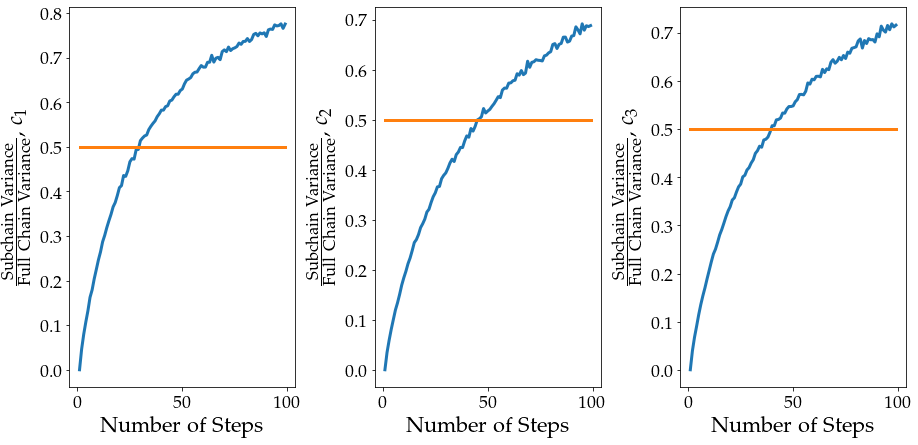

In [17]:
burnin = 500
def calc_corrlength(chain, n):
    
    variance = np.zeros(n.shape)
    
    for i in range(len(variance)):
        n_subchains = len(chain)//n[i]
        x = np.reshape(chain[:n[i]*n_subchains], (n_subchains, n[i]))
        variance[i] = np.mean(np.var(x, axis=1))
        
    return variance

variance_fullchain = np.var(chain[burnin:], axis=0)

f, ax = plt.subplots(1, 3, figsize=(15, 7), gridspec_kw={'wspace':0.35})

for i in range(3):
    n = np.arange(1, 100)
    var = calc_corrlength(chain[burnin:, i], n)
    ax[i].plot(n, var/variance_fullchain[i])
    ax[i].plot(n, n*0 + 0.5)
    ax[i].set_xlabel("Number of Steps")
    ax[i].set_ylabel(r"$\frac{\rm Subchain~ Variance}{\rm Full~Chain~ Variance}$, $c_{%d}$" % (i + 1))


It looks like the correlation length is longest for $c_2$, and is about 50 steps in this parameter.  So, our effective length of the chain is approximately 

$N_{\rm eff} \approx \frac{10^5 - 500}{50} \approx 2000$ steps.

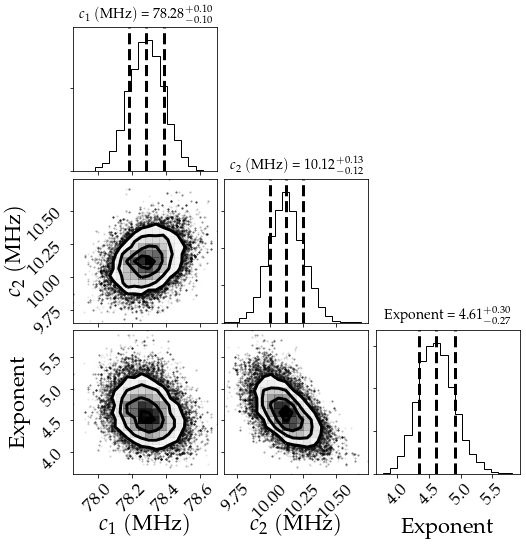

In [18]:
import corner
chain_physunits = chain[burnin:].copy()
chain_physunits[:, :2] *= 75
chain_physunits[:, -1] = chain_physunits[:, -1]**2
cornerplot = corner.corner(chain_physunits[burnin:], 
                           labels=[r"$c_1~({\rm MHz})$", r"$c_2~({\rm MHz})$", r"Exponent"],
                           quantiles=[0.16, 0.5, 0.84],
                           show_titles=True, title_kwargs={"fontsize": 14})

Now I'll import `emcee` and copy down the log likelihood from the homework,

$T[\nu] = b_0 \nu^{-2.5 + b_1 + b_2 \log \nu} e^{-b_3 \nu^{-2}} + b_4 \nu^{-2} + c_0 \exp \left[ - \bigg| \frac{\nu - c_1}{c_2} \bigg|^{2.8} \right]$

and the covariance matrix for the data,

$\langle T_{1} T_{2} \rangle \approx A \delta_{12} + B \cos \left[ \frac{0.3}{\rm MHz} \left( \nu_1 - \nu_2 \right) \right] \exp \left[ -\bigg| \frac{\nu_1 - \nu_2}{60~{\rm MHz}} \bigg| \right]$

In [19]:
import emcee

def log_prob(par, nu, T, Cinv_data):
    model = par[0]*nu**(-2.5 + par[1] + par[2]*np.log(nu))
    model *= np.exp(-par[3]/nu**2)
    model += par[4]/nu**2
    model += par[5]*np.exp(-np.abs((nu - par[6])/par[7])**2.8)
    resid = T - model
    logp = -0.5*np.linalg.multi_dot([resid, Cinv_data, resid])

    return logp
    
nu_x, nu_y = np.meshgrid(nu, nu)
delta_nu_MHz = (nu_x - nu_y)*75
A = 0.025**2
B = 2*A
covar = np.identity(len(nu))*A
covar += B*np.cos(0.3*delta_nu_MHz)*np.exp(-np.abs(delta_nu_MHz)/60)
Cinv_data = np.linalg.inv(covar)

This part will make emcee run.  I am guessing the first five parameters ($b_0$, $b_1$, $b_2$, $b_3$, $b_4$) from Part 1b.  I am guessing $c_0 = 0$, $c_1 = 0.96$, and $c_2 = 0.06$, (using advance knowledge from running this once) with relatively small uncertainties to try to limit the burn-in time.  I'll run a long chain of 10,000 steps so that I can try and see what the burn-in and correlation lengths look like.

In [20]:
nwalkers = 40
nsteps = 10000

# These are guessed from HW2--the first five are from part 1b.
# I refined the guesses a little using my results from below.
#parguess = [ 740, -0.44, -0.69, -0.12, 912, 0, 1, 0.1]
parguess = [ 740, -0.44, -0.69, -0.12, 912, 0, 0.96, 0.06]
sigguess = [10, 0.01, 0.01, 0.01, 10, 0.1, 0.02, 0.01]
ndim = len(parguess)
p0 = np.random.randn(nwalkers, ndim)
p0 = p0*sigguess + parguess

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[nu, T, Cinv_data])
state = sampler.run_mcmc(p0, nsteps)

Now it is time to make plots.  I'll make the plots in $c_1$ and $c_2$.

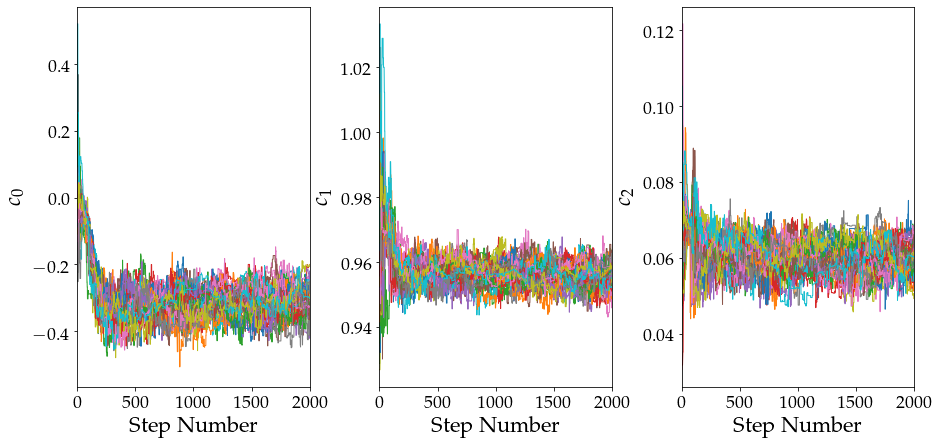

In [21]:
chain_emcee = sampler.get_chain()
# Plot each walker with a separate line.  This is c1.

f, ax = plt.subplots(1, 3, figsize=(15, 7), gridspec_kw={'wspace':0.3})

for var in range(5, 8):
    j = var - 5
    for i in range(chain_emcee.shape[1]):
        ax[j].plot(np.arange(chain_emcee.shape[0]), chain_emcee[:, i, var], lw=1)
    ax[j].set_xlabel("Step Number")
    ax[j].set_ylabel(r"$c_%d$" % (var - 5))
    ax[j].set_xlim(0, 2000)

lnprob = sampler.get_log_prob()[-1]

It took some pretty good initial guesses to burn my chains in.  And I'm still not 100% sure that I have the unique and correct global best-fit, and that there isn't some other mode hiding somewhere!  With slightly worse initial guesses, this looked horrible, with many chains not burned in (with log probabilities much, much worse than the best-fit chain).  I'll first measure the correlation length using all of the chains, and then make a corner plot.

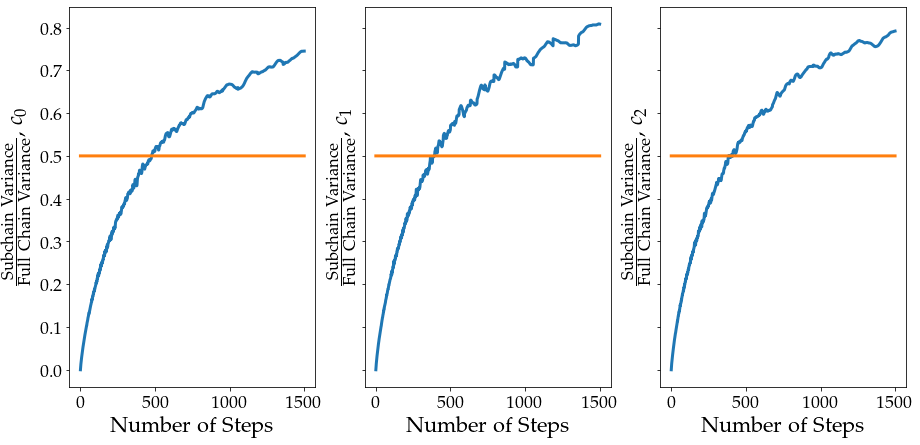

In [22]:
burnin = 500
variance_fullchain = [np.var(chain_emcee[burnin:, :, i]) for i in range(8)]

f, ax = plt.subplots(1, 3, figsize=(15, 7), sharey=True)

for par in range(5, 8):
    n = np.arange(1, 1500)
    var = np.zeros(n.shape)
    # Take the average variance of the subchain across all walkers.
    for walker in range(nwalkers):
        var += calc_corrlength(chain_emcee[burnin:, walker, par], n)/nwalkers
    i = par - 5
    ax[i].plot(n, var/variance_fullchain[par])
    ax[i].plot(n, n*0 + 0.5)
    ax[i].set_xlabel("Number of Steps")
    ax[i].set_ylabel(r"$\frac{\rm Subchain~ Variance}{\rm Full~Chain~ Variance}$, $c_{%d}$" % (i))

Ouch.  The correlation length is now more than 500 steps.  My 40 walkers with 10,000 steps each are only about as good as $\sim$800 independent steps.  We'll make a corner plot to finish this.

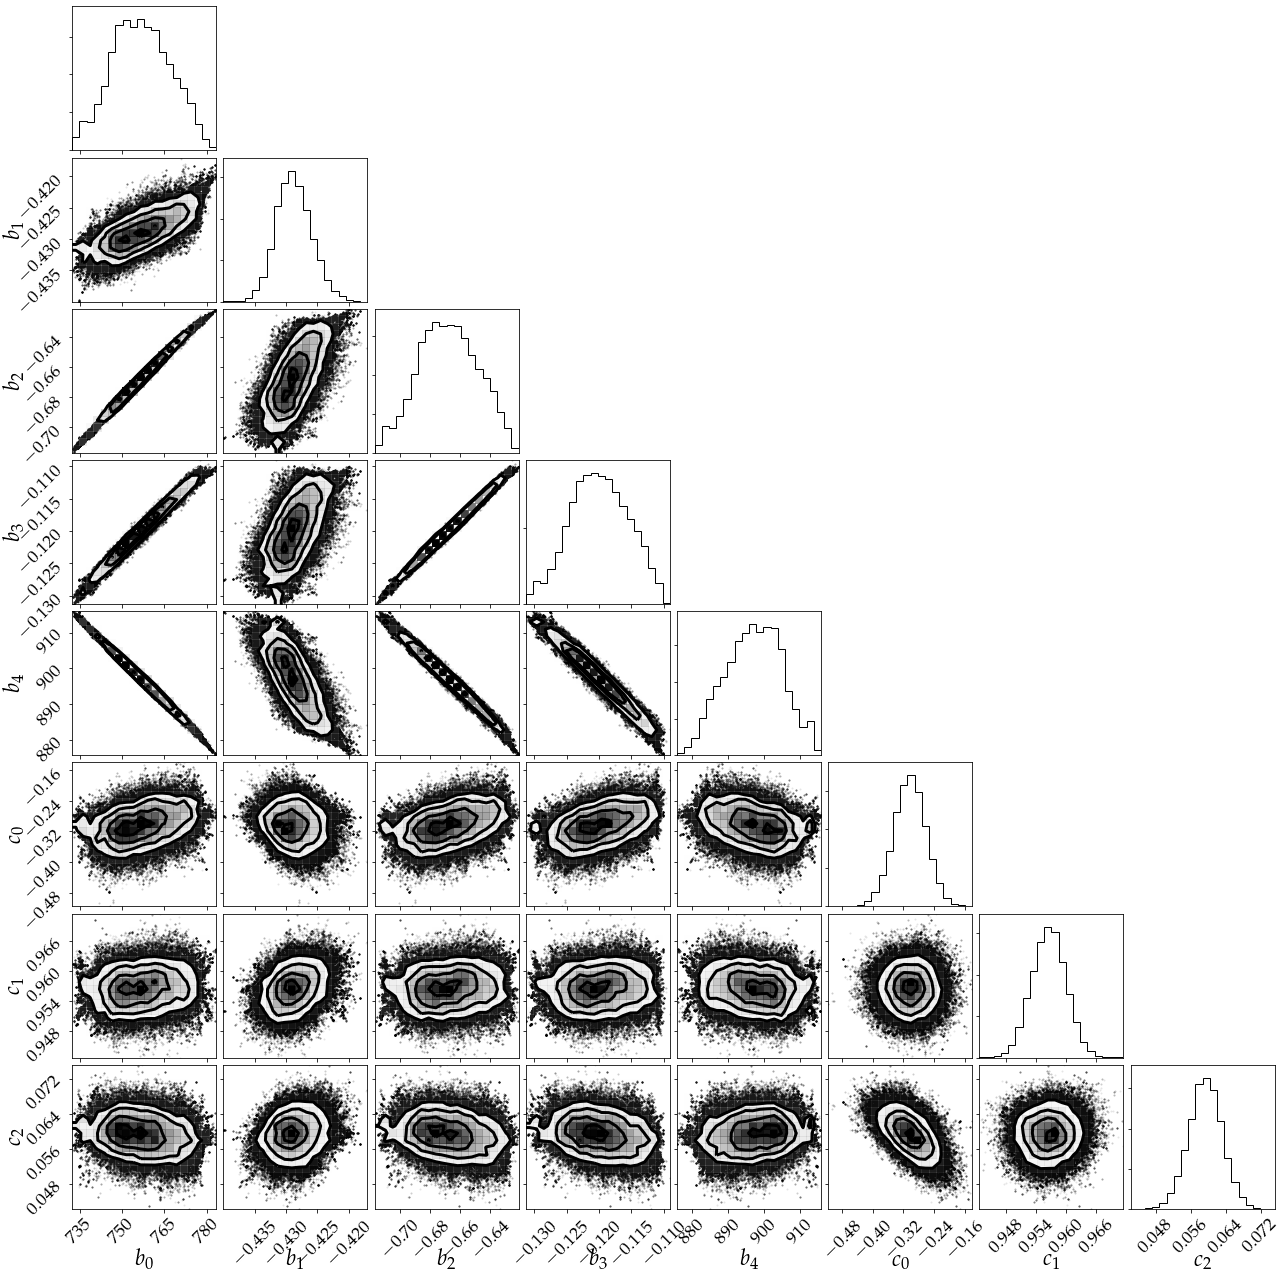

In [23]:
figure = corner.corner(np.reshape(chain_emcee[burnin:], (-1, ndim)), 
                       labels=[r"$b_0$", r"$b_1$", r"$b_2$", r"$b_3$", r"$b_4$", r"$c_0$", r"$c_1$", r"$c_2$"])

# Part 3

The first part will load in the data, subtract the mean image, and perform an SVD to get the basis images.  I'll then plot the mean image and the first two principal components.

Text(5, 165, 'Principal Component 2')

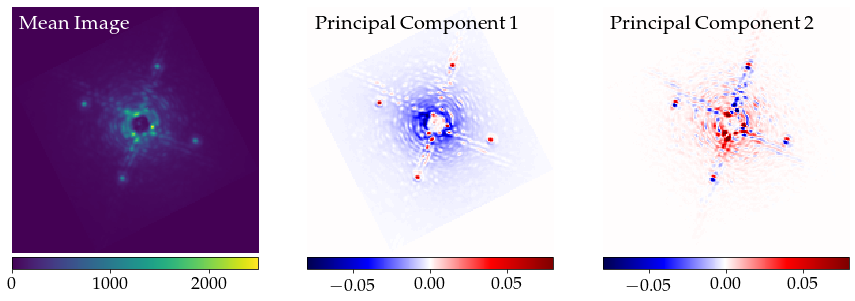

In [24]:
images = fits.open('images.fits')[0].data
meanimage = np.mean(images, axis=0)
images_meansub = images - meanimage
imflat = np.reshape(images_meansub, (len(images), -1)).T
U, W, VT = np.linalg.svd(imflat, full_matrices=False)
basis_images = np.reshape(U.T, images.shape)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))
[ax.axis('off') for ax in [ax1, ax2, ax3]]

f1 = ax1.imshow(meanimage, origin='lower')
plt.colorbar(f1, ax=ax1, orientation='horizontal', pad=0.01)
ax1.text(5, 165, "Mean Image", color='w', fontsize=20)

f2 = ax2.imshow(basis_images[0], vmin=-0.08, vmax=0.08, origin='lower', cmap='seismic')
plt.colorbar(f2, ax=ax2, orientation='horizontal', pad=0.01)
ax2.text(5, 165, "Principal Component 1", fontsize=20)

f3 = ax3.imshow(basis_images[1], vmin=-0.08, vmax=0.08, origin='lower', cmap='seismic')
plt.colorbar(f3, ax=ax3, orientation='horizontal', pad=0.01)
ax3.text(5, 165, "Principal Component 2", fontsize=20)


Now I'll plot how much of the variance is contained in each principal component.  I won't bother including the last principal component, since the data are mean subtracted so they have rank $n-1$.

Text(0, 0.5, 'Cumulative Fraction of Variance')

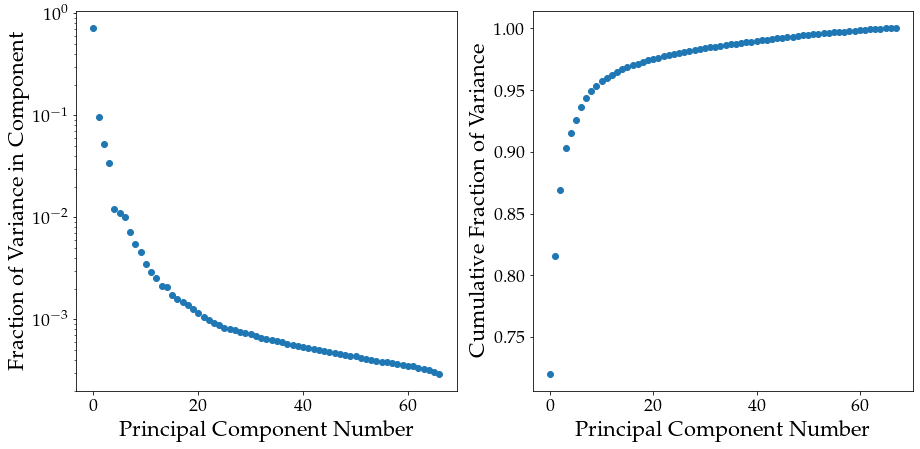

In [25]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.semilogy(np.arange(len(images) - 1), W[:-1]**2/np.sum(W**2), marker='o', linestyle="")
ax1.set_xlabel("Principal Component Number")
ax1.set_ylabel("Fraction of Variance in Component")

ax2.plot(np.arange(len(images)), np.cumsum(W**2)/np.sum(W**2), marker='o', linestyle="")
ax2.set_xlabel("Principal Component Number")
ax2.set_ylabel("Cumulative Fraction of Variance")

There looks to be a nice kink after the fourth principal component, so the first thing I would try is to use four PCs (plus the mean, for five basis images overall).  The first four principal components explain just over 90% of the variance about the mean image.

Now for the last part: I'll add noise using the prescription given in the homework and then reconstruct the basis images.

In [26]:
badpix = (np.random.uniform(0, 1, images.shape) > 0.9999)*(images != 0)
badpixval = np.std(images)*100
images_badpix = images + badpix*np.random.uniform(0, badpixval, images.shape)
im_badpix_meansub = images_badpix - np.mean(images_badpix, axis=0)
imflat_badpix = np.reshape(im_badpix_meansub, (len(images), -1)).T

U_badpix, W_badpix, VT = np.linalg.svd(imflat_badpix, full_matrices=False)
basis_images_badpix = np.reshape(U_badpix.T, images.shape)

Now I'll plot a few principal components for comparison.  There is a lot more residual structure in the images with additional bad pixels; the bad pixels get picked up in the principal components and take up a lot of the structure.

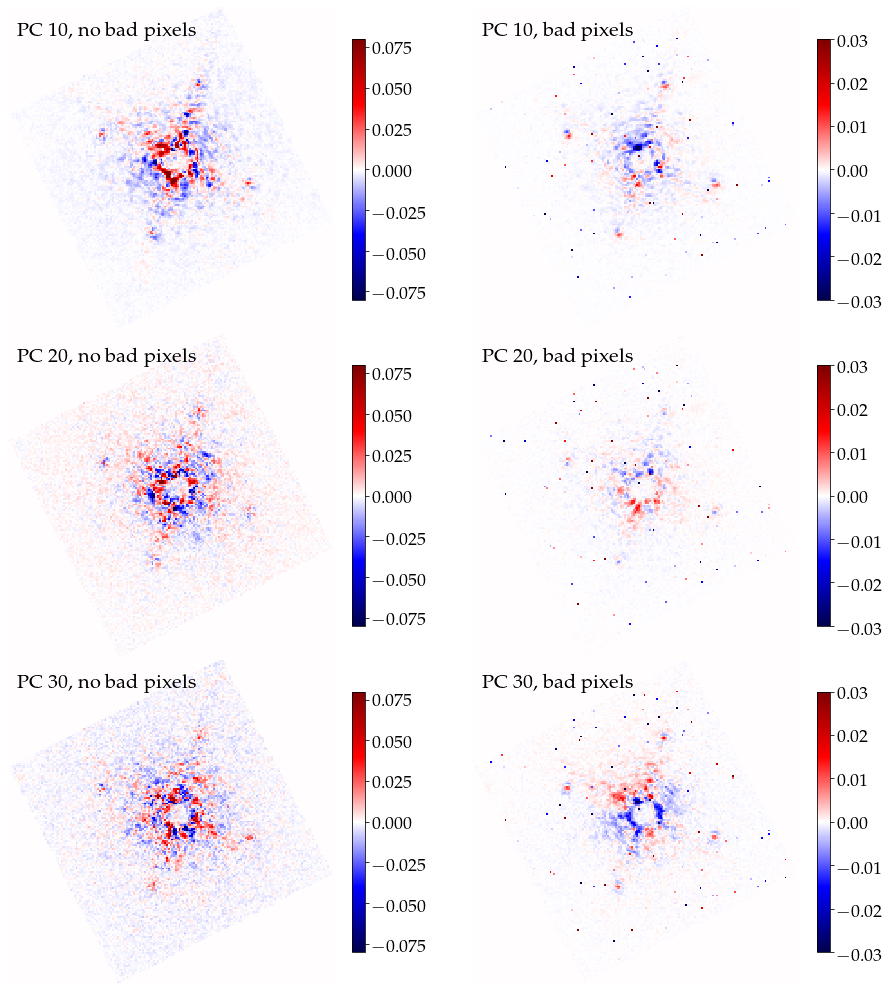

In [27]:
f, axlist = plt.subplots(3, 2, figsize=(15, 18), gridspec_kw={'hspace':0, 'wspace':0.25})

for i in range(3):
    [ax.axis('off') for ax in axlist[i]]
    
    # The principal component I will plot for comparison between the original basis
    # images the the basis images with additional bad pixels
    
    pc = i*10 + 10
    
    f = axlist[i, 0].imshow(basis_images[pc], vmin=-0.08, vmax=0.08, origin='lower', cmap='seismic')
    plt.colorbar(f, ax=axlist[i, 0], orientation='vertical', fraction=0.035)
    axlist[i, 0].text(5, 165, "PC %d, no bad pixels" % (pc), fontsize=20)

    f = axlist[i, 1].imshow(basis_images_badpix[pc], vmin=-0.03, vmax=0.03, origin='lower', cmap='seismic')
    plt.colorbar(f, ax=axlist[i, 1], orientation='vertical', fraction=0.035)
    axlist[i, 1].text(5, 165, "PC %d, bad pixels" % (pc), fontsize=20)


Finally, I'll compare the principal components 

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


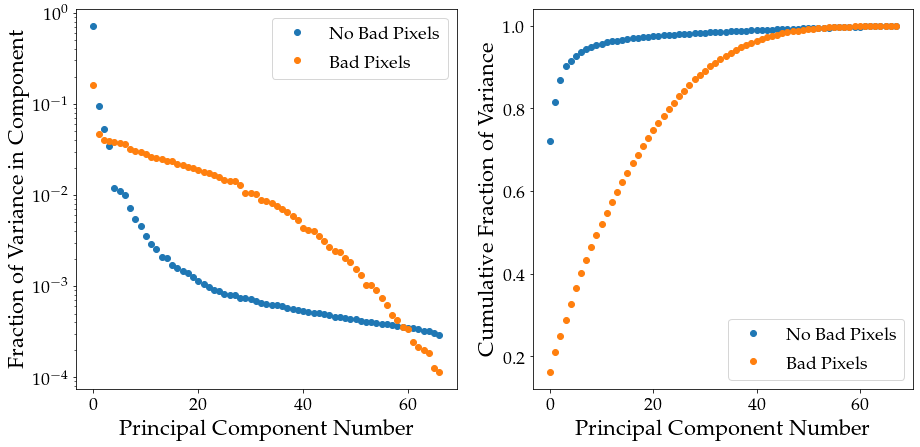

In [28]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.semilogy(np.arange(len(images) - 1), W[:-1]**2/np.sum(W**2), marker='o', linestyle="")
ax1.semilogy(np.arange(len(images) - 1), W_badpix[:-1]**2/np.sum(W_badpix**2), marker='o', linestyle="")
ax1.set_xlabel("Principal Component Number")
ax1.set_ylabel("Fraction of Variance in Component")
ax1.legend(["No Bad Pixels", "Bad Pixels"])

ax2.plot(np.arange(len(images)), np.cumsum(W**2)/np.sum(W**2), marker='o', linestyle="")
ax2.plot(np.arange(len(images)), np.cumsum(W_badpix**2)/np.sum(W_badpix**2), marker='o', linestyle="")
ax2.set_xlabel("Principal Component Number")
ax2.set_ylabel("Cumulative Fraction of Variance")
ax2.legend(["No Bad Pixels", "Bad Pixels"])